## Import the libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Google Drive / Kaggle directory setup

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Read train and test data

In [0]:
train_data = pd.read_hdf('/content/drive/My Drive/Colab Notebooks/block_1_train_data_final.h5')
test_data = pd.read_hdf('/content/drive/My Drive/Colab Notebooks/block_1_test_data_final.h5')

## Create validation data set

In [0]:
val_split = int(len(train_data) * 0.10)
validation_data = train_data[:val_split+1]

In [0]:
train_data.shape, test_data.shape, validation_data.shape

((204740, 3), (37905, 3), (20475, 3))

## Create the LSTM model function

In [0]:
def LSTM_model(train_data=train_data, 
              test_data=test_data, 
              validation_data=validation_data, 
              look_back=30, 
              y_target_col=2, 
              epochs=10, 
              batch_size=64):
 
  # scale data
  scaler = MinMaxScaler()
  train_data = scaler.fit_transform(train_data)
  validation_data = scaler.fit_transform(validation_data)
  
  # get input arrays
  
  X_train = []
  y_train = []

  for i in range(look_back, train_data.shape[0]):
      X_train.append(train_data[i-look_back:i])
      y_train.append(train_data[i, y_target_col])
    
  X_train, y_train = np.array(X_train), np.array(y_train)

  X_val = []
  y_val = []

  for i in range(look_back, validation_data.shape[0]):
    X_val.append(validation_data[i-look_back:i])
    y_val.append(validation_data[i, y_target_col])

  X_val, y_val = np.array(X_val), np.array(y_val)

  # build the model
  model = Sequential()

  model.add(CuDNNLSTM(units=128, 
                      return_sequences=True, 
                      input_shape=(X_train.shape[1], 3)))
  # model.add(Dropout(0.2)) # model has better results w/o Dropout
  model.add(CuDNNLSTM(units=32, return_sequences=True))
  model.add(Flatten())
  model.add(Dense(units=1))

  model.compile(optimizer='adam', loss = 'mean_squared_error')

  # callbacks  
  callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)
  
  callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)
  
  callback_tensorboard = TensorBoard(log_dir='C:\\Users\\Laptop\\Desktop\\tensor')

  callbacks = [callback_early_stopping,
             callback_reduce_lr,
             callback_tensorboard]
  
  # train   
  history = model.fit(X_train, 
                      y_train, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      validation_data=(X_val, y_val), 
                      callbacks=callbacks)

  # predict
  past_60_min = test_data.tail(60)
  df = past_60_min.append(test_data, ignore_index = True)
  inputs = scaler.transform(df)

  X_test = []
  y_test = []

  for i in range(look_back, inputs.shape[0]):
    X_test.append(inputs[i-look_back:i])
    y_test.append(inputs[i, y_target_col])

  X_test, y_test = np.array(X_test), np.array(y_test) 

  y_pred = model.predict(X_test)
  scale = 1/scaler.scale_[y_target_col]
  y_pred = y_pred*scale
  y_test = y_test*scale

  mae = mean_absolute_error(y_test, y_pred)
  mse = np.sqrt(mean_squared_error(y_test, y_pred))
  r2 = r2_score(y_test, y_pred, multioutput='variance_weighted')

  # plot
  plt.figure(figsize=(14,5))
  plt.plot(y_test, color = 'red', label = 'Real')
  plt.plot(y_pred, color = 'blue', label = 'Predicted')
  plt.title('Mill Separator Power')
  plt.xlabel('Minutes')
  plt.ylabel('Separator Power kw')
  plt.legend()
  plt.show()
    
  result = model.evaluate(x=X_test, y=y_test)
  print("loss (test-set):", result)
  print('LSTM: ', mae, mse, r2)
  return y_test, y_pred, history

## Train the LSTM model

Train on 204680 samples, validate on 20415 samples
Epoch 1/10
204680/204680 [==============================] - 52s 255us/sample - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0266 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0169
Epoch 2/10
204672/204680 [============================>.] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0185
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
204680/204680 [==============================] - 52s 253us/sample - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0185 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0210
Epoch 3/10
204672/204680 [============================>.] - ETA: 0s - loss: 9.4767e-04 - mean_squared_error: 9.4767e-04 - mean_absolute_error: 0.0154
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001.
204680/204680 [==============================] -

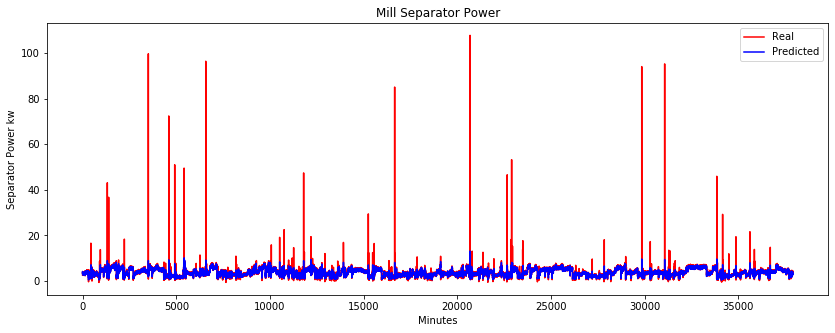

37905/37905 [==============================] - 12s 321us/sample - loss: 14.1360 - mean_squared_error: 14.1360 - mean_absolute_error: 3.2121
loss (test-set): [14.136019452186487, 14.136016, 3.2121434]
LSTM:  0.4800873564596995 1.6240101105575802 0.3913597971365439


In [0]:
y_test, y_pred_lstm, history_lstm = LSTM_model(train_data=train_data, 
              test_data=test_data, 
              validation_data=validation_data, 
              look_back=60, 
              y_target_col=2,
              epochs=10, 
              batch_size=128)

## Code to lunch Tensorboard

In [0]:
tensorboard --logdir C:\Users\Laptop\Desktop\tensor

UsageError: Line magic function `%tensorboard` not found.


## Create the GRU model function

In [0]:
def GRU_model(train_data=train_data, 
              test_data=test_data, 
              validation_data=validation_data, 
              look_back=30, 
              y_target_col=2, 
              epochs=10, 
              batch_size=64):
 
  # scale data
  scaler = MinMaxScaler()
  train_data = scaler.fit_transform(train_data)
  validation_data = scaler.fit_transform(validation_data)
  
  # get input arrays
  
  X_train = []
  y_train = []

  for i in range(look_back, train_data.shape[0]):
      X_train.append(train_data[i-look_back:i])
      y_train.append(train_data[i, y_target_col])
    
  X_train, y_train = np.array(X_train), np.array(y_train)

  X_val = []
  y_val = []

  for i in range(look_back, validation_data.shape[0]):
    X_val.append(validation_data[i-look_back:i])
    y_val.append(validation_data[i, y_target_col])

  X_val, y_val = np.array(X_val), np.array(y_val)

  # build the model
  model = Sequential()

  model.add(CuDNNGRU(units=128, 
                     return_sequences=True, 
                     input_shape=(X_train.shape[1], 3)))
  #model.add(Dropout(0.5))
  model.add(CuDNNGRU(units=32, return_sequences=True))
  model.add(Flatten())
  model.add(Dense(units=1))

  model.compile(optimizer='adam', 
                loss = 'mean_squared_error',  
                metrics=['mse', 'mae'])

  # callbacks  
  callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, 
                                        verbose=1)
  
  callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)
  
  callback_tensorboard = TensorBoard(log_dir='C:\\Users\\Laptop\\Desktop\\tensor')

  callbacks = [callback_early_stopping,
             callback_reduce_lr,
             callback_tensorboard]
  
  # train   
  history = model.fit(X_train, 
                      y_train, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      validation_data=(X_val, y_val), 
                      callbacks=callbacks)

  # predict
  past_60_min = test_data.tail(60)
  df = past_60_min.append(test_data, ignore_index = True)
  inputs = scaler.transform(df)

  X_test = []
  y_test = []

  for i in range(look_back, inputs.shape[0]):
    X_test.append(inputs[i-look_back:i])
    y_test.append(inputs[i, y_target_col])

  X_test, y_test = np.array(X_test), np.array(y_test) 

  y_pred = model.predict(X_test)
  scale = 1/scaler.scale_[y_target_col]
  y_pred = y_pred*scale
  y_test = y_test*scale

  mae = mean_absolute_error(y_test, y_pred)
  mse = np.sqrt(mean_squared_error(y_test, y_pred))
  r2 = r2_score(y_test, y_pred, multioutput='variance_weighted')

  # plot
  plt.figure(figsize=(15,5))
  plt.plot(y_test, color = 'red', label = 'Real')
  plt.plot(y_pred, color = 'blue', label = 'Predicted')
  plt.title('Mill Separator Power')
  plt.xlabel('Minutes')
  plt.ylabel('Separator Power kw')
  plt.legend()
  plt.show()
    
  result = model.evaluate(x=X_test, y=y_test)
  print("loss (test-set):", result)
  print('GRU: ', mae, mse, r2)
  return y_test, y_pred, history

## Train the GRU model

In [0]:
y_test, y_pred_gru, history_gru = GRU_model(train_data=train_data, 
              test_data=test_data, 
              validation_data=validation_data, 
              look_back=60, 
              y_target_col=2,
              epochs=10, 
              batch_size=128)

## Plot the results

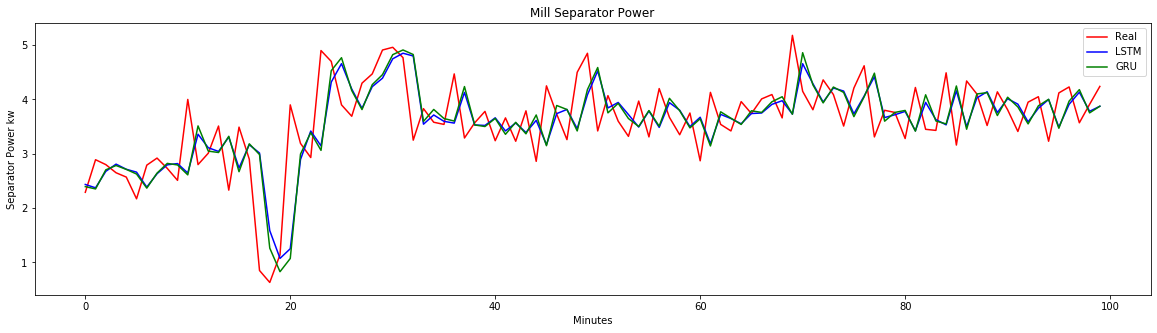

In [0]:
# plot
a = 28000
b = a+100
plt.figure(figsize=(20,5))
plt.plot(y_test[a:b], color = 'red', label = 'Real')
plt.plot(y_pred_lstm[a:b], color = 'blue', label = 'LSTM')
plt.plot(y_pred_gru[a:b], color = 'green', label = 'GRU')
plt.title('Mill Separator Power')
plt.xlabel('Minutes')
plt.ylabel('Separator Power (kw)')
plt.legend()
plt.show()

## Model metrics

In [0]:
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
r2_lstm = r2_score(y_test, y_pred_lstm, multioutput='variance_weighted')

mae_gru = mean_absolute_error(y_test, y_pred_gru)
mse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))
r2_gru = r2_score(y_test, y_pred_gru, multioutput='variance_weighted')

print('Block 1 Metrics')
print('LSTM: ', mae_lstm, mse_lstm, r2_lstm)
print('GRU: ', mae_gru, mse_gru, r2_gru)

## Save the results

In [0]:
y_test1 = y_test.flatten()
y_pred_lstm1 = y_pred_lstm.flatten()
y_pred_gru1 = y_pred_gru.flatten()

In [0]:
block_1_results = pd.DataFrame({'y_test': y_test1, 'y_pred_lstm': y_pred_lstm1, 'y_pred_gru': y_pred_gru1})

In [0]:
block_1_results

In [0]:
block_1_results.to_hdf('block_1_results.h5', key='df')